<a href="https://colab.research.google.com/github/Tabitha001/ML-Customer-Churn-Analysis-in-Banking/blob/main/Utilizing_ML_Driven_Churn_Analysis_to_Optimize_Customer_Retention_Strategies_in_Banking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project entails utilizing machine learning techniques to analyze customer churn and improve retention strategies in the banking sector. It combines machine learning techniques with data analysis to address the issue of customer churn in the banking industry

In essence, the project aims to understand customer churn, which refers to customers leaving a service or business. In the banking context, it involves customers closing accounts, discontinuing credit cards, or moving their finances elsewhere. Understanding the reasons behind churn is critical for a bank's growth and profitability.

And in the heart of the project, machine learning algorithms will be used to build predictive models that can forecast which customers are likely to churn.

In [43]:
#import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pickle
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
from google.colab import files

uploaded = files.upload()


Saving Customer-Churn-Records.csv to Customer-Churn-Records.csv


In [4]:
import io
data = io.BytesIO(uploaded['Customer-Churn-Records.csv'])

In [5]:
df = pd.read_csv(data)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [6]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain',
       'Satisfaction Score', 'Card Type', 'Point Earned'],
      dtype='object')

In [7]:
df = df.rename (columns = {'CreditScore' : 'credit_score', 'NumOfProducts' : 'num_of_products', 'HasCrCard' : 'has_credit_card',
       'IsActiveMember' : 'is_active_member', 'EstimatedSalary' : 'estimeted_salary',
       'Satisfaction Score' : 'satisfaction_score', 'Card Type' : 'card_type', 'Point Earned' : 'point_earned'})

## understanding what each column means


RowNumber: An identifier for each row in the dataset. It seems to represent the sequential order of entries.

CustomerId: Unique identifier for each customer.

Surname: The last name or surname of the customer.

CreditScore: A numerical value representing the creditworthiness of the customer. Higher values indicate better credit scores.

Geography: The country where the customer is located, such as "France" or "Spain".

Gender: The gender of the customer, typically "Female" or "Male".

Age: The age of the customer in years.

Tenure: The number of years the customer has been with the bank.

Balance: The amount of money in the customer's account.

NumOfProducts: The number of bank products that the customer has (e.g., accounts, credit cards).

HasCrCard: Whether the customer has a credit card (1 for yes, 0 for no).

IsActiveMember: Whether the customer is an active member of the bank (1 for yes, 0 for no).

EstimatedSalary: The estimated annual salary of the customer.

Exited: Whether the customer has exited or churned from the bank (1 for churned, 0 for not churned).

Complain: Whether the customer has made a complaint (1 for yes, 0 for no).

Satisfaction Score: A numerical score indicating the customer's satisfaction level (usually on a scale).

Card Type: The type of card the customer holds (e.g., "DIAMOND", "GOLD"). This might be related to the customer's loyalty status or benefits.

Point Earned: The number of loyalty or reward points earned by the customer.

In [8]:
df.shape

(10000, 18)

The dataset has 10,000 rows and 18 columns

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   credit_score        10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   num_of_products     10000 non-null  int64  
 10  has_credit_card     10000 non-null  int64  
 11  is_active_member    10000 non-null  int64  
 12  estimeted_salary    10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  satisfaction_score  10000 non-null  int64  
 16  card_

In [10]:
df.describe()

,RowNumber,CustomerId,credit_score,Age,Tenure,Balance,num_of_products,has_credit_card,is_active_member,estimeted_salary,Exited,Complain,satisfaction_score,point_earned
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,606.515100
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,225.924839
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,5.000000,1000.000000


In [11]:
df.isna().sum().sum()

0

In [12]:
# check for duplicates
df.duplicated().value_counts()

False    10000
dtype: int64

There are no duplicates

No missing values

## EXPLORATORY DATA ANALYSIS

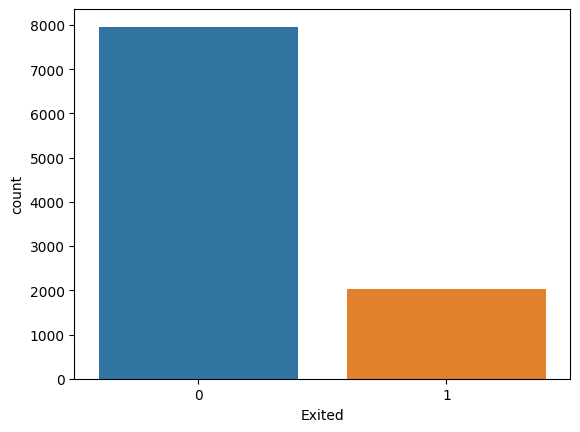

In [13]:
# countplot of the target variable
sns.countplot(x = df['Exited']);

There is an imbalance in the target class.

The class imbalance will be address with the oversampling method

<Axes: xlabel='Exited', ylabel='count'>

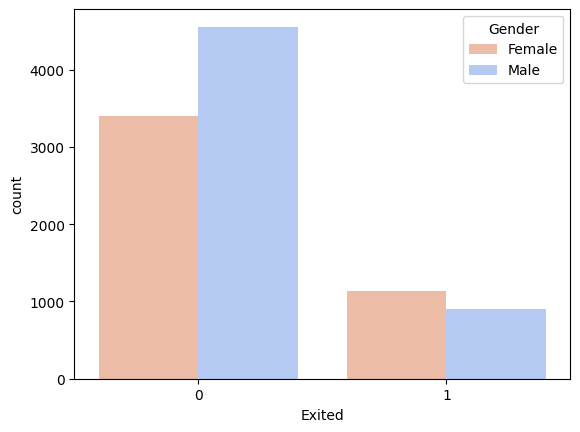

In [14]:
sns.countplot(x='Exited',data=df,hue='Gender',palette="coolwarm_r")

accurate conclusion cannot really be drawn from the graph above, but it somehow appears that more females exited the bank than males

<Axes: xlabel='Exited', ylabel='count'>

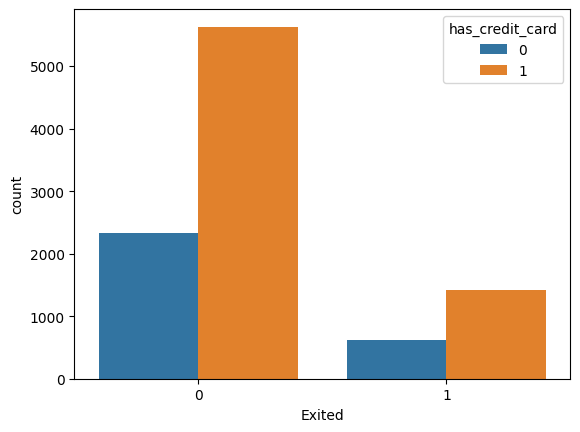

In [15]:
#Churn Analysis by Credit Card Usage
sns.countplot(x='Exited',data=df, hue='has_credit_card')

some people with credit card exited the bank. There might be an issue that customers are facing with the credit card. it could indicate a specific issue or lack of engagement with credit card services. Though this is still an inconclusive insight because more of the customers that didn't exit the bank also have credit card

SUGGESTION:

The Bank should develop targeted campaigns to educate non-active credit card holders about the benefits and perks associated with their credit cards.

<Axes: xlabel='Exited', ylabel='count'>

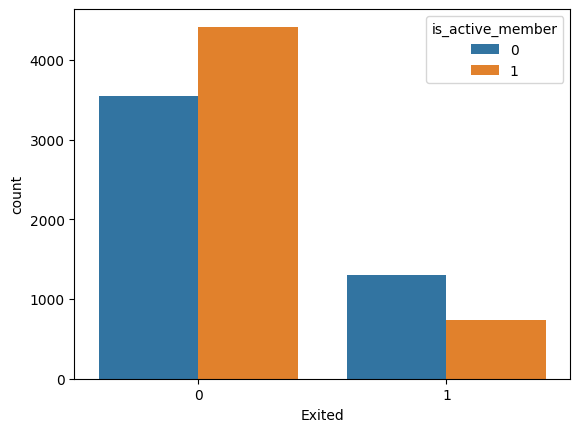

In [16]:
# Churn Analysis by Customer Activity
sns.countplot(x='Exited',data=df, hue='is_active_member')

INSIGHTS: In terms of activeness, none active customers exited the bank than the active members.

SUGGESTIONS: The Bank should Consider implementing targeted engagement strategies for non-active customers, such as personalized offers, reminders about the benefits of the bank's services, or educational content about financial management.

Also, the bank should Enhance communication channels to keep customers informed about new services, offers, and improvements, thereby encouraging more frequent interactions.

<Axes: xlabel='Exited', ylabel='count'>

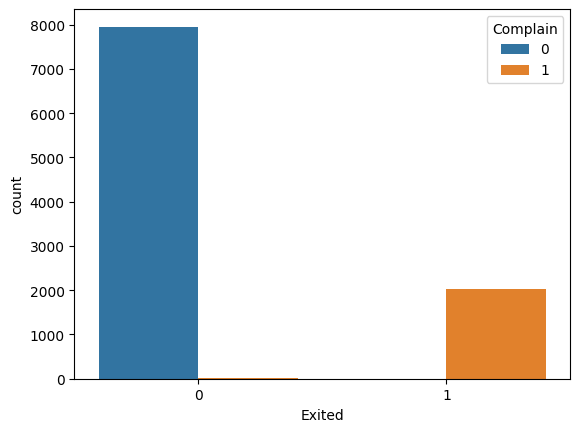

In [17]:
sns.countplot(x='Exited',data=df, hue='Complain')

<Axes: xlabel='Exited', ylabel='count'>

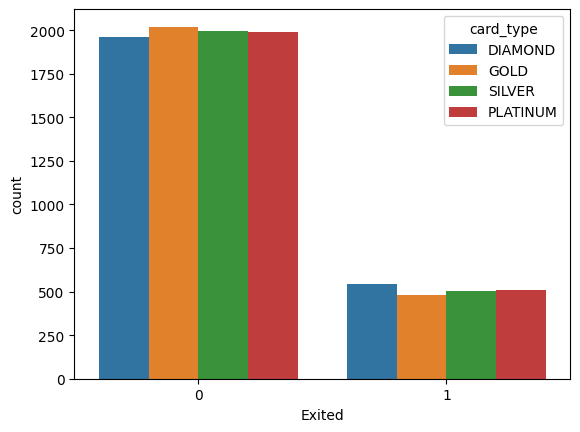

In [18]:
#Churn Analysis by Credit Card type
sns.countplot(x='Exited',data=df, hue='card_type')

<Axes: xlabel='Exited', ylabel='count'>

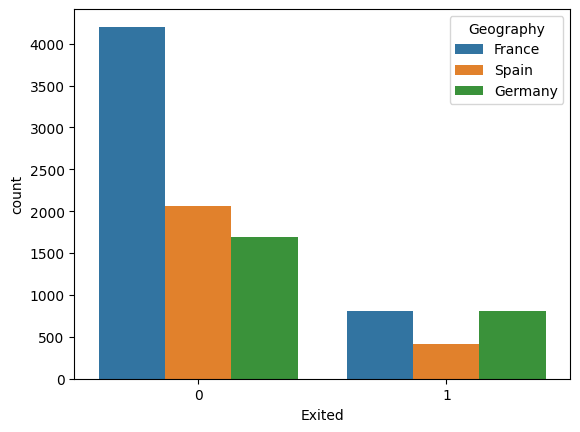

In [19]:
# Churn Analysis by Country
sns.countplot(x='Exited',data=df, hue='Geography')

INSIGHTS: of the customers from france, spain, and germany, most of the customers that did not churn are from france


Investigate what factors might be contributing to the lower churn rate among French customers. Are there specific services or features that are more popular in France?

Based on the insights derived from the visualizations of the columns,here are some recommendations that the bank could consider:

-Enhance Customer Engagement:

Focus on improving customer engagement strategies, especially for non-active customers. Targeted campaigns, personalized offers, and reminders about the bank's services could encourage higher engagement.


-Credit Card Services Improvement:

If there is evidence that customers with credit cards are churning at a higher rate, investigate and address the issues they might be facing. Gather feedback and make necessary improvements to credit card services to enhance customer satisfaction.


-Leverage French Customer Insights:

Given the observation that a larger proportion of non-churned customers are from France, analyze the factors that contribute to this trend. Identify successful strategies and features that are working well in France and explore their potential applicability in other regions.



-Targeted Communication:

Develop communication strategies that highlight the benefits of the bank's services, especially credit card benefits, to non-active customers. This could reignite interest and encourage them to engage with the bank.


-Personalized Engagement:

Utilize data-driven insights to personalize engagement efforts. Tailor communications and offers to individual customer preferences and behavior, enhancing the likelihood of positive responses.


In [20]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'credit_score', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'num_of_products',
       'has_credit_card', 'is_active_member', 'estimeted_salary', 'Exited',
       'Complain', 'satisfaction_score', 'card_type', 'point_earned'],
      dtype='object')

# DATA PREPROCESSING

In [21]:
df.head()

,RowNumber,CustomerId,Surname,credit_score,Geography,Gender,Age,Tenure,Balance,num_of_products,has_credit_card,is_active_member,estimeted_salary,Exited,Complain,satisfaction_score,card_type,point_earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [22]:
#encoding categorical variables
encoder = LabelEncoder()

columns = ['Geography','Gender', 'card_type']
for column in columns:
  df[column] = encoder.fit_transform(df[column])

In [23]:
#split data into input and target variables
x = df.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
y = df['Exited']

addressing the clas imbalance in the target column

In [24]:
#Oversampling of the minority class in the target column

oversample = RandomOverSampler(sampling_strategy='not majority')
x_sampled, y_sampled = oversample.fit_resample(x, y)

x = x_sampled
y = y_sampled


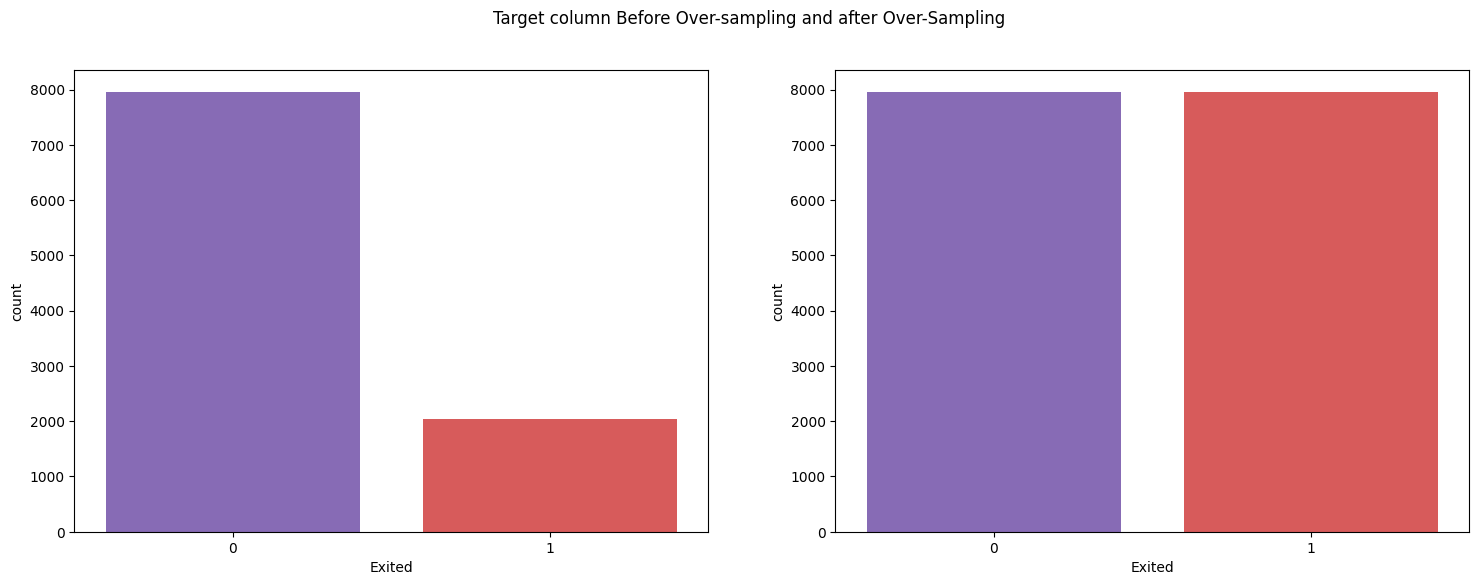

In [25]:
#visualize the oversampling results
plt.figure(figsize=(18,6))
plt.suptitle('Target column Before Over-sampling and after Over-Sampling')
plt.subplot(1,2,1)
sns.countplot(x = df['Exited'], palette=['#845ec2','#ec4646'])
plt.subplot(1,2,2)
sns.countplot(data=pd.DataFrame(y),x = 'Exited', palette=['#845ec2','#ec4646'] )
plt.show()

In [26]:
x.head()

,credit_score,Geography,Gender,Age,Tenure,Balance,num_of_products,has_credit_card,is_active_member,estimeted_salary,Complain,satisfaction_score,card_type,point_earned
0,619,0,0,42,2,0.00,1,1,1,101348.88,1,2,0,464
1,608,2,0,41,1,83807.86,1,0,1,112542.58,1,3,0,456
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1,3,0,377
3,699,0,0,39,1,0.00,2,0,0,93826.63,0,5,1,350
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0,5,1,425


#MODEL TRAINING

In [27]:
#split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

model algorithm

-XGBoost (Extreme Gradient Boosting)

In [30]:
model = xgb.XGBClassifier(
    learning_rate=0.5,
    max_depth=6,
    n_estimators=150,
    use_label_encoder=False,
    objective='binary:logistic',
    eval_metric='logloss',
    reg_alpha=0.3,
    reg_lambda=0.1,
    gamma=0.5,
    )

In [32]:
model.fit(x_train, y_train)
model_pred = model.predict(x_test)


print(confusion_matrix(y_test, model_pred))

[[2460    3]
 [   2 2313]]


In [33]:
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2463
           1       1.00      1.00      1.00      2315

    accuracy                           1.00      4778
   macro avg       1.00      1.00      1.00      4778
weighted avg       1.00      1.00      1.00      4778



Classification Report:

Precision: The model's ability to correctly classify positive samples (class 1) is very high, with a precision of 1.00. This means that almost all instances classified as positive are indeed positive.

Recall: The model also has excellent recall for both classes, indicating that it correctly identifies the majority of positive and negative instances. A recall of 1.00 suggests that very few positive instances were missed (false negatives) and that almost all were correctly identified.

F1-Score: The F1-score is the harmonic mean of precision and recall. It's a measure that combines both precision and recall into a single value. With an F1-score of 1.00, the model achieves perfect balance between precision and recall.

Accuracy: The overall accuracy of the model is 1.00, which means it correctly predicts all instances in the test dataset.

In summary, the model appears to be performing exceptionally well on the given dataset, achieving perfect precision, recall, and F1-score for both classes, and an overall accuracy of 1.00. But this could also mean that the model is likely overfitting the training data, as it's performing almost too well.

To assess the model's generalization performance, let's consider cross-validation

CROSS-VALIDATION

we calculate and print the cross-validation scores for each fold and the mean accuracy across all folds.

This will give a more reliable estimate of the model's performance and help to assess if it generalizes well to unseen data. If the cross-validation scores are consistent and high, then model is likely to be a good fit for the data.

If there is a significant drop in performance during cross-validation compared to the training results initially gotten, it might indicate overfitting, and there may need to adjust the model or its hyperparameters.

In [37]:

# Define XGBoost classifier with the desired hyperparameters
model = xgb.XGBClassifier(
    learning_rate=0.5,
    max_depth=6,
    n_estimators=150,
    use_label_encoder=False,
    objective='binary:logistic',
    eval_metric='logloss',
    reg_alpha=0.3,
    reg_lambda=0.1,
    gamma=0.5,
)

# Perform 10-fold cross-validation
scores = cross_val_score(model, x_train, y_train, cv=10, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())


Cross-Validation Scores: [1.         0.99910314 0.99820628 0.99910314 0.99910314 0.99910314
 1.         0.99820467 0.99820467 1.        ]
Mean Accuracy: 0.9991028169807826


The cross-validation scores continue to show very high accuracy, with some minor fluctuations across folds. However, the results indicate certain things:

The cross-validation scores for each fold are consistently close to 1.00, indicating that the model consistently performs at a high level on different subsets of the training data.

The mean accuracy across all folds is approximately 0.9991, which is extremely high. This further reinforces the notion that the model is well-suited to the dataset and can generalize effectively to unseen data.

Given these results, it appears that the XGBoost model is performing exceptionally well and consistently, even with different subsets of the training data. This suggests that the model has learned meaningful patterns in the data and is likely to make accurate predictions on new, unseen data.

In [44]:
#save model
with open("bank_churn_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [46]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
